In [393]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

dfs=[]
for file in glob.glob("*.json"):
    dataframe = pd.read_json(file)['posts']
    # flatten the structure
    dataframe = pd.json_normalize(dataframe)
    # insert file names
    dataframe['file_name'] = os.path.basename(file)
    dfs.append(dataframe)

# concatenate all data and drop repeated entries
df=pd.concat(dfs).drop_duplicates(subset='uuid', keep='last')

In [394]:
selected_columns = [
    'file_name',
    'uuid', 
    'title',
    'content',
    'post_flair_text',
    'author',
    'author_flair_text',
    'created',
    'comments',
    'score_up',
    'preview',
    'tweet_id',
    'domain',
    'is_image',
    'is_video',
    'video_link'
    ]	

df = df[selected_columns]
# replace empty cell with Nan
dataframe = dataframe.replace(r'^\s*$', np.nan, regex=True)

# format datetime
df['created'] = pd.to_datetime(df.created, unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
# crate a column storing "date" 
df['created_date'] = df['created'].dt.date
df['created_date'] = df['created_date'].astype(str)



df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192 entries, 240 to 26
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype                     
---  ------             --------------  -----                     
 0   file_name          192 non-null    object                    
 1   uuid               192 non-null    object                    
 2   title              192 non-null    object                    
 3   content            192 non-null    object                    
 4   post_flair_text    192 non-null    object                    
 5   author             192 non-null    object                    
 6   author_flair_text  192 non-null    object                    
 7   created            192 non-null    datetime64[ns, US/Eastern]
 8   comments           192 non-null    int64                     
 9   score_up           192 non-null    int64                     
 10  preview            192 non-null    object                    
 11  tweet_id           192 

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_5338/1962686270.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe = dataframe.replace(r'^\s*$', np.nan, regex=True)


In [406]:
df.created_date.value_counts().sort_index()

created_date
2024-07-19    67
2024-07-20    71
2024-07-21    54
Name: count, dtype: int64

In [445]:
help(contractions)

Help on package contractions:

NAME
    contractions

PACKAGE CONTENTS
    data (package)
    test___init__

FUNCTIONS
    add(key, value)

    fix(s, leftovers=True, slang=True)

    get_combinations(tokens, joiners)

    intersperse(lst, item)

    preview(text, flank)
        Return all contractions and their location before fix for manual check. Also provide a viewing window to quickly
        preview the contractions in the text.
        :param text: texture.
        :param flank: int number, control the size of the preview window. The window would be "flank-contraction-flank".
        :return: preview_items, a list includes all matched contractions and their locations.

DATA
    comb = "you'd've"
    contractions_dict = {"'cause": 'because', "'em": 'them', "'tis": 'it i...
    json_open = b'{\n     "\'aight": "alright",\n     "abt": "ab...a": "wa...
    k = 'you’d’ve'
    leftovers_dict = {"'all": '', "'am": '', "'cause": 'because', "'coz": ...
    month = 'december'
    replacer

In [448]:
import spacy
from nltk import bigrams, trigrams
nlp = spacy.load('en_core_web_lg')
stopwords = list(nlp.Defaults.stop_words)

# remove additional stopwords, such as Trump
stopwords.append('trump')

import contractions
import emoji
import re
from tqdm import tqdm
tqdm.pandas()


def clean_it_all_up (text):
    text = emoji.replace_emoji(text)
    text = contractions.fix(text)
    text = re.sub(r'\W+', ' ', text)
    doc = nlp(text)
    lemmatized_tokens = []
    
    for token in doc:
        if (
            token.text.lower() not in stopwords
            and token.pos_ in {'NOUN', 'PROPN'} 
            and token.ent_type_ not in {'GPE', 'LOC'}
        ):
          
            
            lemmatized_tokens.append(token.lemma_.lower())
            
    return " ".join(lemmatized_tokens)   

def nice_tokens_plus(targeted_date):
    cleaned_tokens = ' '.join(df[df['created_date'] == targeted_date]['title'].progress_apply(clean_it_all_up).tolist())
    return cleaned_tokens

def one_words_plus(targeted_date):
    cleaned_tokens = ' '.join(df[df['created_date'] == targeted_date]['title'].progress_apply(clean_it_all_up).tolist())
    uni_grams = pd.Series(cleaned_tokens.split()).value_counts()
    top_unigrams = uni_grams[uni_grams > 1].head()
    return top_unigrams

def two_words_plus(targeted_date):
    cleaned_tokens = ' '.join(df[df['created_date'] == targeted_date]['title'].progress_apply(clean_it_all_up).tolist())
    bi_grams = pd.Series(bigrams(cleaned_tokens.split())).value_counts()
    # set baseline appearance at 2
    top_bigrams = bi_grams[bi_grams > 1].head()
    return top_bigrams

In [458]:
def ngram_generator(num, date):
    cleaned_tokens = ' '.join(df[df['created_date'] == date]['title'].progress_apply(clean_it_all_up).tolist())
    if num == 1:
        ngram = pd.Series(cleaned_tokens.split()).value_counts()
    elif num == 2:
        ngram = pd.Series(list(bigrams(cleaned_tokens.split()))).value_counts()
    elif num == 3:
        ngram = pd.Series(list(trigrams(cleaned_tokens.split()))).value_counts()
    else:
        raise ValueError('Invalid number. Must choose between 1, 2, or 3.')
    
    ngram = ngram[ngram > 1].head()
    return ngram


In [459]:
ngram_generator(3, '2024-07-21')

100%|██████████| 54/54 [00:00<00:00, 223.06it/s]


(biden, dems, decision)        2
(decision, biden, dems)        2
(kamala, harris, president)    2
Name: count, dtype: int64

In [424]:
from wordcloud import WordCloud

In [460]:
def ngram_cloud(num, date):
    ngram = ngram_generator(num, date)
    words_cloud = pd.DataFrame(ngram, columns=['count']).reset_index().rename(columns={'index': 'phrases'})
    words_cloud['phrases'] = words_cloud['phrases'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)
    words_cloud['phrases'] = words_cloud['phrases'].str.replace(',', '')
    wordcloud = WordCloud(width=800, height=400, background_color='white').\
    generate_from_frequencies(bi_wordcloud.set_index('phrases')['count'].to_dict())
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

100%|██████████| 67/67 [00:00<00:00, 246.46it/s]


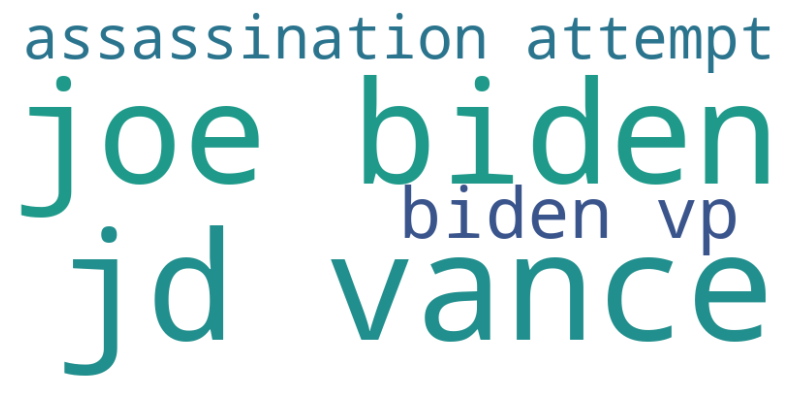

In [461]:
ngram_cloud(2, "2024-07-19")

In [462]:
# A summary table of authors based on a given date
def frequent_accounts(date):
    top_authors = df[df['created_date'] == date]['author'].value_counts().reset_index()
    top_authors = top_authors[top_authors['count']>1]
    comments_total = df.groupby('author').comments.sum()
    upvotes_total = df.groupby('author').score_up.sum()
    top_authors =  top_authors.merge(comments_total, on='author').merge(upvotes_total, on='author')
    top_authors = top_authors.rename(columns={'author': 'top_authors',
                                      'count': 'top_articles',
                                      'comments': 'accumulated_comments',
                                      'score_up': 'accumulated_upvotes'
                                      })
    top_authors = top_authors.sort_values('top_articles', ascending=False)
    return  top_authors

In [463]:
date = "2024-07-19"

frequent_accounts(date)

,top_authors,top_articles,accumulated_comments,accumulated_upvotes
0,rdvs34283,6,1012,8678
1,I-am-Orlando,5,1623,19925
2,Trump_Is_My_Daddy,4,241,3435
3,trees65,4,2325,18235
4,TheRedPilledArtist,3,799,4269
5,Sea_Still,3,384,5088
6,MythArcana,3,261,2975
7,Mr_Rightside,2,545,4412
8,FuckAllDemocrats,2,108,1366
9,davidac1982,2,392,5063
